# Neural Network Project
### Team Members: Ilias Sarantopoulos, Artem Tsikiridis
#### This project was done as part of the Machine Learning course for the MSc in Computer Science, Athens University of Economics and Business

<img src="neural.png" </img>
                                

The matrix of the partial derivatives of the cost function for $W^{(1)}$ of this neural network is:

$$ \nabla E({W^{(1)}}) = W^{(2)T} \cdot (T - S)^T \times grad_h(X \cdot W^{(1)T})^T  \cdot X$$

where $grad_h( \cdot )$ is the gradient of the chosen activation function and $W^{(2)}$ contains no bias.
The matrix of the partial derivatives of the cost function for $W^{(2)}$ of this neural network is:
$$ \nabla E({W^{(2)}}) = (T - S)^T \cdot Z - \lambda  \cdot W^{(2)} $$

Some of the activation functions and their derivatives can be expressed via the sigmoid function:

$$\sigma(a) = \frac{1}{1 + e^{-a}}$$

We have the following 3 activation functions and their derivatives:

1) Logarithmic Function

$$h(a)= \log(1+e^{a})$$

$$\frac{\partial h(a)}{\partial a} = \sigma(a)$$

2) Tanh Function

$$h(a) = \frac{e^{a}-e^{-a}}{e^{a}+e^{-a}} = 2 \sigma (2a) -1$$

$$\frac{\partial h(a)}{\partial a} = 1 - h(a)^2$$

3) Cosine Function

$$h(a)= \cos(a)$$

$$\frac{\partial h(a)}{\partial a} = -\sin(a)$$

# Loading data and initializing network
We start the neural network by loading all the data. In order to efficiently train the neural network we will need to normalize the pixels. We divide each pixel value by the maximum value it can take (so its 255 for every pixel).

In [3]:
%matplotlib inline
from __future__ import division
import matplotlib.pyplot as plt
# import matplotlib.image as mpimg
import numpy as np
from PIL import Image


def load_data():
    """
    Loads the MNIST dataset. Reads the training files and creates matrices.
    :return: train_data:the matrix with the training data
    test_data: the matrix with the data that will be used for testing
    train_truth: the matrix consisting of one hot vectors on each row(ground truth for training)
    test_truth: the matrix consisting of one hot vectors on each row(ground truth for testing)
    """
    train_files = ['data/train%d.txt' % (i,) for i in range(10)]
    test_files = ['data/test%d.txt' % (i,) for i in range(10)]
    tmp = []
    for i in train_files:
        with open(i, 'r') as fp:
            tmp += fp.readlines()
    # load train data in N*D array (60000x784 for MNIST) divided by 255 to achieve normalization
    train_data = np.array([[j for j in i.split(" ")] for i in tmp], dtype='int')  / 255
    print "Train data array size: ", train_data.shape
    tmp = []
    for i in test_files:
        with open(i, 'r') as fp:
            tmp += fp.readlines()
    # load test data in N*D array (10000x784 for MNIST) divided by 255 to achieve normalization
    test_data = np.array([[j for j in i.split(" ")] for i in tmp], dtype='int') / 255
    print "Test data array size: ", test_data.shape
    tmp = []
    for i, _file in enumerate(train_files):
        with open(_file, 'r') as fp:
            for line in fp:
                tmp.append([1 if j == i else 0 for j in range(0, 10)])
    train_truth = np.array(tmp, dtype='int')
    del tmp[:]
    for i, _file in enumerate(test_files):
        with open(_file, 'r') as fp:
            for _ in fp:
                tmp.append([1 if j == i else 0 for j in range(0, 10)])
    test_truth = np.array(tmp, dtype='int')
    print "Train truth array size: ", train_truth.shape
    print "Test truth array size: ", test_truth.shape
    return train_data, test_data, train_truth, test_truth

if __name__ == '__main__':
    train_data, test_data, train_truth, test_truth = load_data()
    
  

Train data array size:  (60000, 784)
Test data array size:  (10000, 784)
Train truth array size:  (60000, 10)
Test truth array size:  (10000, 10)


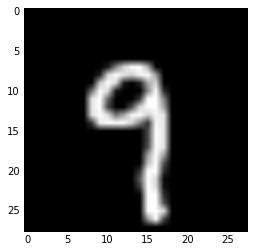

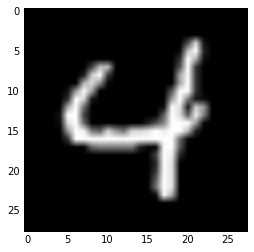

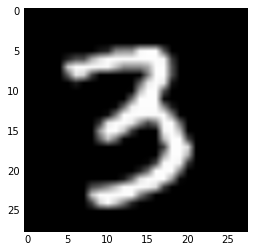

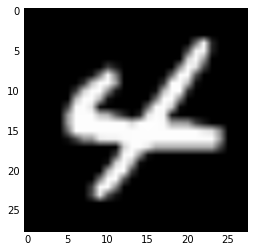

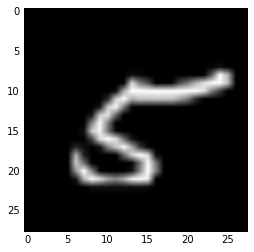

In [4]:
    # Running this block will display 5 handwritten digits from the training dataset
    samples = np.random.randint(train_data.shape[0], size=5)
    for i in samples:
        im = Image.fromarray(train_data[i].reshape(28,28)*255).convert('RGB')
        plt.figure()
        plt.imshow(im)

Afterwards we initialize the weights of $W^{(1)}$ matrix and $W^{(2)}$. $W^{(2)}$ weights can also be initialized to zero. But the initialization of $W^{(1)}$ weights is really important for the performance of our neural network and since we will be using gradient ascent it is useful to initialize weights very close to zero. So we initialize $W^{(1)}$ of dimensions  M x D+1 (that is (number of hidden layer neurons) x 784 for this case) in the space between [-0.1, 0.1].
So now we are ready to start training our network. 
We start forward propagation in our network. First we add the bias to W1 (a column of ones) and we pass the parameters $ x\cdot W^{(1)} $  in the activation function, and then we calculate $z = h(x \cdot W1)$. Then we add a bias column to $z$. Afterwards we calculate $ y = z \cdot W^{(2)} $ and then the softmax probabilities of $y$. The final step is backpropagation and the computation of the partial derivatives of the cost function (gradw1 and gradw2) with which we calculate the new weight matrices of $W^{(1)}$ and $W^{(2)}$.
Below you can see the function that does the above steps    

In [ ]:
def forward_prop(self, x, t, w1, w2):
        """
        Do the forward propagation and get error, gradw2 and gradw1
        :param x:
        :param t:
        :param w1:
        :param w2:
        :return: error, gradw1 and gradw2
        """
        # feed forward
        z = self.hidden_activation(np.dot(x, w1.T))
        # add bias to z
        z_with_bias = np.concatenate((np.ones((z.shape[0], 1)), z), axis=1)
        # multiplication and transpose
        y = np.dot(z_with_bias, w2.T)
        max_error = np.max(y, 1)
        E = np.sum(t * y) - np.sum(max_error) - \
            np.sum(np.log(np.sum(np.exp(y - np.array([max_error, ] * self.number_of_outputs).T), 1))) - \
            (0.5 * self.lamda) * np.sum(w2 * w2)
        s = softmax(y)
        # calculate gradient of W2
        gradw2 = np.dot((t - s).T, z_with_bias) - self.lamda * w2
        # calculate gradient of W1 (we get rid of the bias from w2)
        gradw1 = (w2[:, 1:].T.dot((t - s).T) * self.grad_activation(x.dot(w1.T)).T).dot(x)
        return E, gradw1, gradw2

# Experiments

We have 3 different type of experiments:
1. 500 Iterations for [100,200,300,400,500] number of neurons in the hidden layer and lambda = 0.1 for the 3 activation functions (15 runs)
2. The same as the first but this time with lambda = 0.2
3. We ran 500 iterations for lambda= 0.08 and lambda= 0.15 once for each activation function using 250 hidden layer neurons
4. Finally we ran 1000 iterations for the configuration from the above that got the best error rate: lambda = 0.2, cosine as activation function and 400 neurons in the hidden layer


| **Activation Function ** |**#of Iterations**| **#of Neurons** | **lambda**| ** Cost Function Value ** | ** Error rate**|
| -------------|:--------:| -----:|:------:|:-------------:|:-------------:|
|logarithmic | 500 | 100 | 0.1 | -10815.1068593| 5.29% |
|logarithmic | 500 | 200 | 0.1 | -10152.3702764| 4.98% |
|logarithmic | 500 | 300 | 0.1 | -10209.7076872| 5.05% |
|logarithmic | 500 | 400 | 0.1 | -10642.6619305| 5.4% |
|logarithmic | 500 | 500 | 0.1 | -9924.8805866| 4.89% |
|tanh | 500 | 100 | 0.1 | -8831.68314194| 4.37% |
|tanh | 500 | 200 | 0.1 | -8008.88984218| 4.18% |
|tanh | 500 | 300 | 0.1 | -7596.02299722| 4.12% |
|tanh | 500 | 400 | 0.1 | -7270.02328235| 3.95% |
|tanh | 500 | 500 | 0.1 | -7284.34882972| 4.07% |
|cosine | 500 | 100 | 0.1 | -6239.59832508| 3.72% |
|**cosine** | **500** | **200** | **0.1** | **-4560.51663596**| **3.27%** |
|cosine | 500 | 300 | 0.1 | -3827.14798839| 3.51% |
|cosine | 500 | 400 | 0.1 | -3232.14279616| 3.63% |
|cosine | 500 | 500 | 0.1 | -2941.6498504| 3.49%|

| **Activation Function ** |**#of Iterations**| **#of Neurons** | **lambda**| ** Cost Function Value ** | ** Error rate**|
| -------------|:--------:| -----:|:------:|:-------------:|:-------------:|
|logarithmic | 500 | 100 | 0.2 | -11391.159748| 5.73% |
|logarithmic | 500 | 200 | 0.2 | -10079.1849541| 5.05% |
|logarithmic | 500 | 300 | 0.2 | -10061.4668903| 5.08% |
|logarithmic | 500 | 400 | 0.2 | -10594.7538012| 5.09% |
|logarithmic | 500 | 500 | 0.2 | -10504.0826878| 5.14% |
|tanh | 500 | 100 | 0.2 | -8811.89283368| 4.68% |
|tanh | 500 | 200 | 0.2 | -8219.18159881| 4.34% |
|tanh | 500 | 300 | 0.2 | -7699.85685918| 4.14% |
|tanh | 500 | 400 | 0.2 | -7707.37692133| 4.21% |
|tanh | 500 | 500 | 0.2 | -7045.31837391| 3.76% |
|cosine | 500 | 100 | 0.2 | -5588.91497828| 3.35% |
|cosine | 500 | 200 | 0.2 | -4613.3932205| 3.74% |
|cosine | 500 | 300 | 0.2 | -4055.03703347| 3.26% |
|**cosine** |** 500 **|** 400** |** 0.2 **| **-3381.77394548**|** 3.12%**|
|cosine | 500 | 500 | 0.2 | -2922.70384446| 3.54%|

| **Activation Function ** |**#of Iterations**| **#of Neurons** | **lambda**| ** Cost Function Value ** | ** Error rate**|
| -------------|:--------:| -----:|:------:|:-------------:|:-------------:|
|logarithmic | 500 | 250 | 0.08 | -10131.3547131| 5.18% |
|tanh | 500 | 250 | 0.08 | -7658.34723213| 4.0% |
|cosine | 500 | 250 | 0.08 | -4354.00077237| 3.64%|

| **Activation Function ** |**#of Iterations**| **#of Neurons** | **lambda**| ** Cost Function Value ** | ** Error rate**|
| -------------|:--------:| -----:|:------:|:-------------:|:-------------:|
|logarithmic | 500 | 250 | 0.15 | -10546.5220427| 5.19% |
|tanh | 500 | 250 | 0.15 | -7714.38709726| 3.91% |
|cosine | 500 | 250 | 0.15 | -4242.84952444| 3.37% |

| **Activation Function ** |**#of Iterations**| **#of Neurons** | **lambda**| ** Cost Function Value ** | ** Error rate**|
| -------------|:--------:| -----:|:------:|:-------------:|:-------------:|
|**cosine** |** 1000** | **400** |** 0.2** |** -1789.24024682**|** 2.76% **|
